# Lab 2 : Supervised Learning

## 1) Data visualization and pre-processing

In [46]:
import numpy as np
import pylab as plt
import scipy as sp
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time


In [4]:
data = np.load("ECoG.npz")

Xall = data["Xall"]
Yall = data["Yall"]
Fe = data["Fe"]

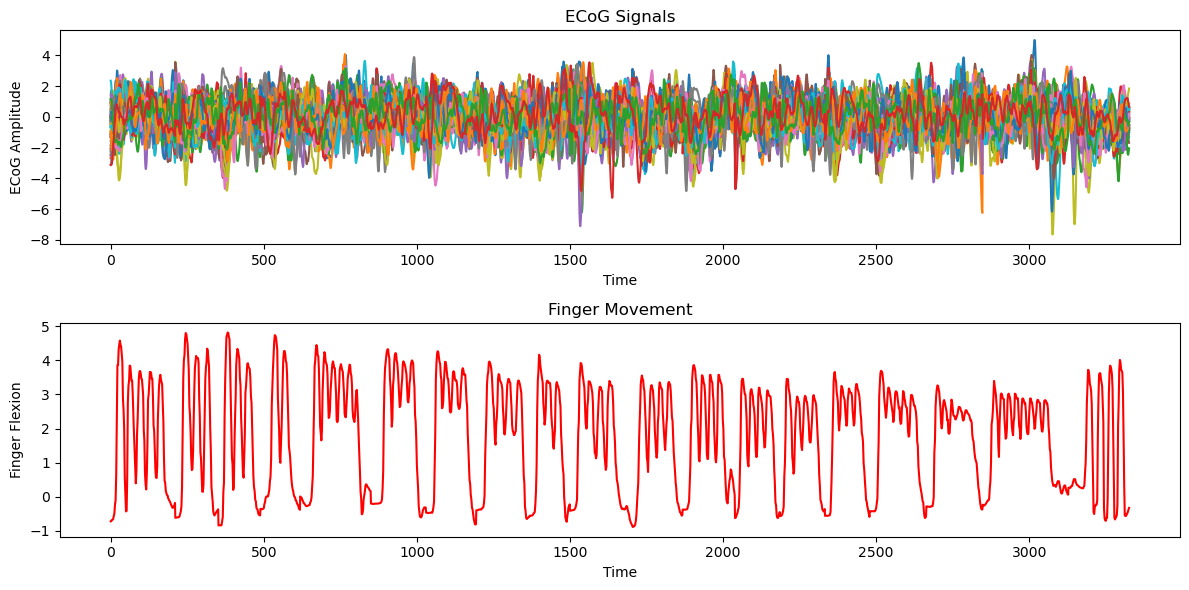

In [5]:
# Plot ECoG signals and finger movement on the same figure
plt.figure(figsize=(12, 6))

# Plot ECoG signals
plt.subplot(2, 1, 1)  # Create the first subplot for ECoG signals
plt.title('ECoG Signals')
plt.xlabel('Time')
plt.ylabel('ECoG Amplitude')
plt.plot(Xall, label='ECoG Signals')

# Plot finger movement
plt.subplot(2, 1, 2)  # Create the second subplot for finger movement
plt.title('Finger Movement')
plt.xlabel('Time')
plt.ylabel('Finger Flexion')
plt.plot(Yall, label='Finger Flexion', color='red')

# Show the plot
plt.tight_layout()
plt.show()

- In the first plot, we observe 64 signals originating from electrodes connected to the subjects' brains.

- In the second plot, the signals correspond to their finger movements. The signal clearly exhibits approximately 20 instances of finger flexion, accompanied by some noise. This noise may be attributed to the fact that when the subject stretches their finger, it tends to exhibit minor vibrations.

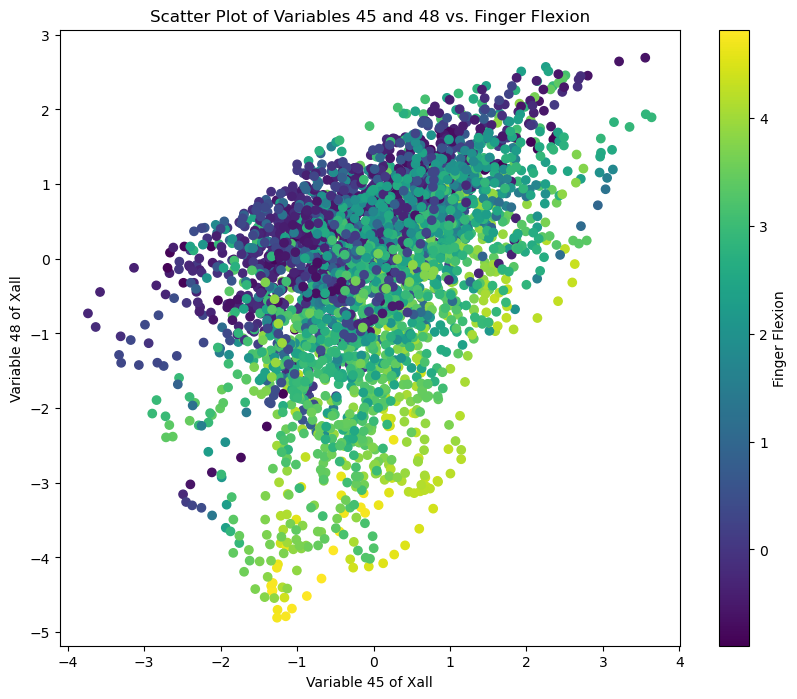

In [6]:
# Variables 45 and 48 from Xall
X45 = Xall[:, 45]
X48 = Xall[:, 48]

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X45, X48, c=Yall, marker='o')
plt.colorbar(label='Finger Flexion')
plt.xlabel('Variable 45 of Xall')
plt.ylabel('Variable 48 of Xall')
plt.title('Scatter Plot of Variables 45 and 48 vs. Finger Flexion')
plt.show()

This scatter plot represents a comparison between the readings from sensor 45 and sensor 48.
The color variations indicate finger flexion. This graph is particularly intriguing because it unmistakably reveals the connection between the readings from sensors 45 and 48 and the flexion of the finger. As an example, when sensor 48's values decrease, the corresponding color shifts towards yellow, signifying a significant angle of finger flexion.

We will try to check this by applying a linear regression on our dataset.

In [7]:
# Define the number of training samples
n_train = 1000

# Split the data into training and testing sets
X_train = Xall[:n_train, :]
Y_train = Yall[:n_train]
print("X_train shape : ",X_train.shape)
print("Y_train shape : ",Y_train.shape)

X_test = Xall[n_train:, :]
Y_test = Yall[n_train:]
print("X_test shape : ",X_test.shape)
print("Y_test shape : ",Y_test.shape)



X_train shape :  (1000, 64)
Y_train shape :  (1000, 1)
X_test shape :  (2327, 64)
Y_test shape :  (2327, 1)


We have divided our data into training and test sets, and in some cases, a validation set may also have been considered. As specified in the lab instructions, we have selected 1000 samples for our training dataset. This results in our test set being more than twice the size of the training set.

This is intriguing because in my previous experiences, I've often used test sets that were smaller in comparison to the training sets, such as a 1/3 ratio. This leads to the question: wouldn't it be beneficial to have a smaller test set, allowing us to allocate more data for training purposes?

## 2) Least Squares regression (LS)


In [8]:
n_train_samples, n_features = X_train.shape

# Create a column of ones
ones_column = np.ones((n_train_samples, 1))

# Concatenate the ones column with the training data
X_tilde = np.concatenate((ones_column, X_train), axis=1)
print(X_tilde.shape)

(1000, 65)


In [9]:

# Solve the linear problem using the normal equation
XTX = np.dot(X_tilde.T, X_tilde)  # X^T * X
XTY = np.dot(X_tilde.T, Y_train)  # X^T * Y

# Solve for the coefficients (w) including the bias term
params = np.linalg.solve(XTX, XTY)

# Extract the coefficients (w) and the bias (b)
w = params[1:]  # Exclude the first element which is the bias term
b = params[0]   # The first element is the bias term

# w now contains the coefficients, and b contains the bias term

In [10]:
# Calculate predictions on the training set
Y_train_pred = np.dot(X_tilde, np.concatenate(([b], w)))

# Calculate predictions on the test set
X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
Y_test_pred = np.dot(X_test_tilde, np.concatenate(([b], w)))

We create a function to plot our results for training data as well as for test data.

In [11]:
def plot_train_test(train, test, method, time=False):

    # Calculate time points based on the sampling frequency Fe
    time_points_test = np.arange(Y_test.shape[0]) / Fe
    time_points_test = time_points_test.flatten()

    # Calculate time points based on the sampling frequency Fe for training data
    time_points_train = np.arange(Y_train.shape[0]) / Fe
    time_points_train = time_points_train.flatten()

    # Plot the predictions vs. true values for training data
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)

    if time:
        plt.plot(time_points_train, Y_train, label='True Y (Training)')
        plt.plot(time_points_train, train, label='Predicted Y (Training)', linestyle='dashed')
    else:
        plt.plot(Y_train, label='True Y (Training)')
        plt.plot(train, label='Predicted Y (Training)', linestyle='dashed')

    plt.title(f'Training Data: True vs. Predicted Finger Flexion ({method})')
    plt.legend()

    # Plot the predictions vs. true values for test data
    plt.subplot(2, 1, 2)

    if time :
        plt.plot(time_points_test, Y_test, label='True Y (Test)')
        plt.plot(time_points_test, test, label='Predicted Y (Test)', linestyle='dashed')
    else:
        plt.plot(Y_test, label='True Y (Test)')
        plt.plot(test, label='Predicted Y (Test)', linestyle='dashed')
    plt.title(f'Test Data: True vs. Predicted Finger Flexion ({method})')
    plt.legend()

    plt.tight_layout()
    plt.show()

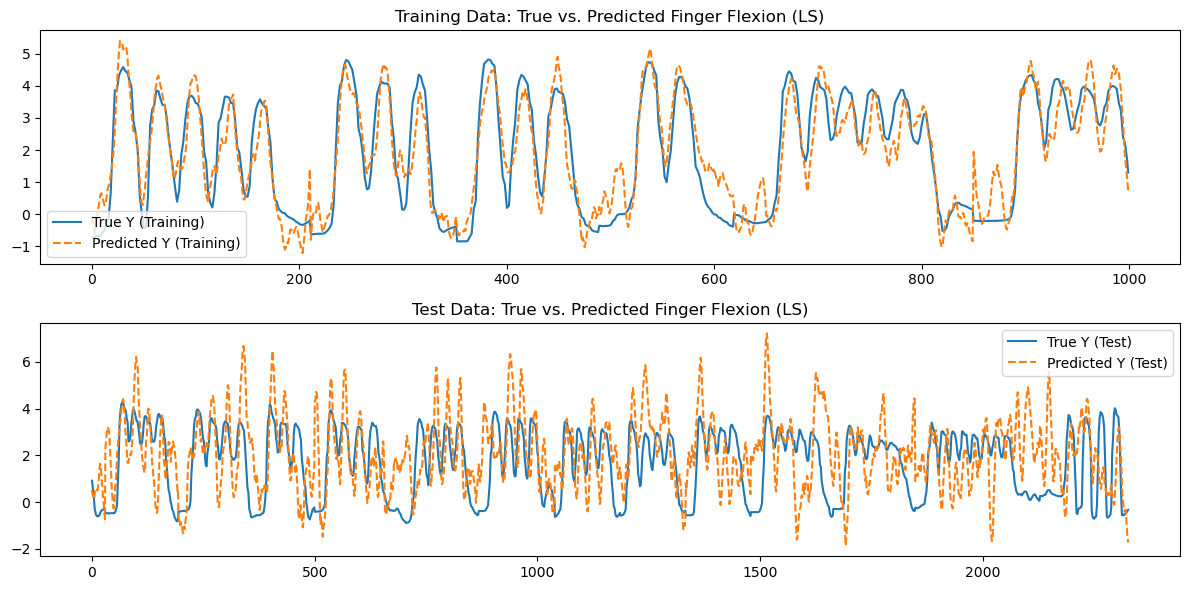

In [12]:
plot_train_test(train=Y_train_pred, test=Y_test_pred, method='LS', time=False)

- We have achieved satisfactory results on the training data, even though the model is facing challenges in accurately learning the transitions between different flexion states. However, the results on the training set are not our primary focus, as a favorable outcome on the training set does not necessarily translate to a favorable one on the test set.

- On the test set, the model's performance appears to be less promising. It lacks precision and seems to struggle when adjusting the amplitude of the curves. We will examine whether these observations are reflected in our performance metrics, specifically the Mean Squared Error (MSE) and R-squared (R2)

In [13]:
# Calculate MSE and R2 on training data
mse_train_ls = mean_squared_error(Y_train, Y_train_pred)
r2_train_ls = r2_score(Y_train, Y_train_pred)

# Calculate MSE and R2 on test data
mse_test_ls = mean_squared_error(Y_test, Y_test_pred)
r2_test_ls = r2_score(Y_test, Y_test_pred)

# Print the results
print(f"Training MSE: {mse_train_ls:.4f}")
print(f"Training R2: {r2_train_ls:.4f}")
print(f"Test MSE: {mse_test_ls:.4f}")
print(f"Test R2: {r2_test_ls:.4f}")

Training MSE: 0.5041
Training R2: 0.8395
Test MSE: 3.0455
Test R2: -0.4282


As expected, the least squares regression model demonstrates strong performance on the training data. These results imply that the model effectively accounts for a substantial portion of the variance within the training dataset.

However, when it comes to the test dataset, the model doesn't exhibit the same level of proficiency. There, the Test MSE reaches a notably higher value at 3.0455, and the Test R2 turns negative, with a value of -0.4282. These test results, with their elevated MSE and negative R2, unmistakably point to a situation where the model struggles to adapt to new, previously unseen data.

The negative R2 value in this context indicates that the model's predictive performance is inferior to a basic approach of using the mean of the data as a reference point.

In [14]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, Y_train)

# Get the estimated coefficients and intercept from the model
sklearn_coefs = model.coef_
sklearn_intercept = model.intercept_

Now, we aim to perform a direct linear regression using sklearn to verify the quality of the model we manually constructed. We have confidence in the validity of our initial model, and we anticipate obtaining the same coefficients. Thus, we should also obtained the same R2 and MSE.

In [15]:
# Compare Linear regreassion results with the previously estimated coefficients and intercept
print(f"Coefficients match : {np.allclose(sklearn_coefs, w.T)}")
print(f"Intercepts match : {np.allclose(sklearn_intercept, b)}")

Coefficients match : True
Intercepts match : True


In [16]:
print("R2 for training data : ",model.score(X_train,Y_train))

R2 for training data :  0.8395001217500111


As expected, we get the same results for coefficients, intercepts and socre.

## 3) Ridge regression

In [17]:
def train_and_evaluate_ridge(alpha, print_results=True):
    # Create a Ridge regression model with the specified alpha
    ridge_model = Ridge(alpha=alpha)

    # Fit the Ridge model to the training data
    ridge_model.fit(X_tilde, Y_train)

    # Predictions on the training set
    Y_train_pred_ridge = ridge_model.predict(X_tilde)

    # Predictions on the test set
    X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    Y_test_pred_ridge = ridge_model.predict(X_test_tilde)


    # Calculate performance metrics on training and test data
    mse_train_ridge = mean_squared_error(Y_train, Y_train_pred_ridge)
    r2_train_ridge = r2_score(Y_train, Y_train_pred_ridge)
    mse_test_ridge = mean_squared_error(Y_test, Y_test_pred_ridge)
    r2_test_ridge = r2_score(Y_test, Y_test_pred_ridge)

    params_ridge = {
        "Y_train_pred_ridge" : Y_train_pred_ridge,
        "Y_test_pred_ridge" : Y_test_pred_ridge,
        "mse_train_ridge" : mse_train_ridge,
        "r2_train_ridge" : r2_train_ridge,
        "mse_test_ridge" : mse_test_ridge,
        "r2_test_ridge" : r2_test_ridge
    }

    if print_results:
        print(f"Ridge Regression with λ = {alpha}\n")
        print(f"Training MSE: {mse_train_ridge:.4f}")
        print(f"Training R2: {r2_train_ridge:.4f}")
        print(f"Test MSE: {mse_test_ridge:.4f}")
        print(f"Test R2: {r2_test_ridge:.4f}")

    return params_ridge

In [18]:
params_ridge = train_and_evaluate_ridge(alpha=1, print_results=True)

Ridge Regression with λ = 1

Training MSE: 0.5042
Training R2: 0.8395
Test MSE: 3.0038
Test R2: -0.4086


For a Ridge regression with λ = 1, we get exactly the same resulsts that for a linear regression. It is clearly not surprising because as we have seen in course, it's corresponds exactly to do an LS algorithm.

Ridge regression is defined like this : 

 $$ \min_{\beta} \left( ||\mathbf{y} - \mathbf{X}\beta||_2^2 + \lambda||\beta||_2^2 \right) $$

 Now, when λ = 1 in ridge regression, we have:

 $$ \min_{\beta} \left( ||\mathbf{y} - \mathbf{X}\beta||_2^2 + 1\cdot||\beta||_2^2 \right) $$

It's effectively the same as performing least squares (LS) regression, which is:

$$\min_{\beta} ||\mathbf{y} - \mathbf{X}\beta||_2^2$$



In [19]:
# Define a range of λ values
lambda_values = np.logspace(-3, 5, 100)  # From 10^-3 to 10^5

# Initialize lists to store MSE values and coefficients for each λ
mse_train_values = []
mse_test_values = []
coefficients = []

# Iterate over λ values
for alpha in lambda_values:
    # Create a Ridge regression model with the current λ
    ridge_model = Ridge(alpha=alpha)

    # Fit the Ridge model to the training data
    ridge_model.fit(X_tilde, Y_train)

    # Predictions on the training set
    Y_train_pred_ridge = ridge_model.predict(X_tilde)

    # Predictions on the test set
    X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    Y_test_pred_ridge = ridge_model.predict(X_test_tilde)

    # Calculate MSE on training and test data
    mse_train = mean_squared_error(Y_train, Y_train_pred_ridge)
    mse_test = mean_squared_error(Y_test, Y_test_pred_ridge)

    # Store MSE values
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

    # Store coefficients for this λ
    coefficients.append(ridge_model.coef_)

# Convert the lists to arrays for plotting
mse_train_values = np.array(mse_train_values)
mse_test_values = np.array(mse_test_values)
coefficients = np.array(coefficients)

# Find the index of the minimum test MSE value
best_lambda_index = np.argmin(mse_test_values)

# Get the λ value corresponding to the minimum test MSE
best_lambda = lambda_values[best_lambda_index]

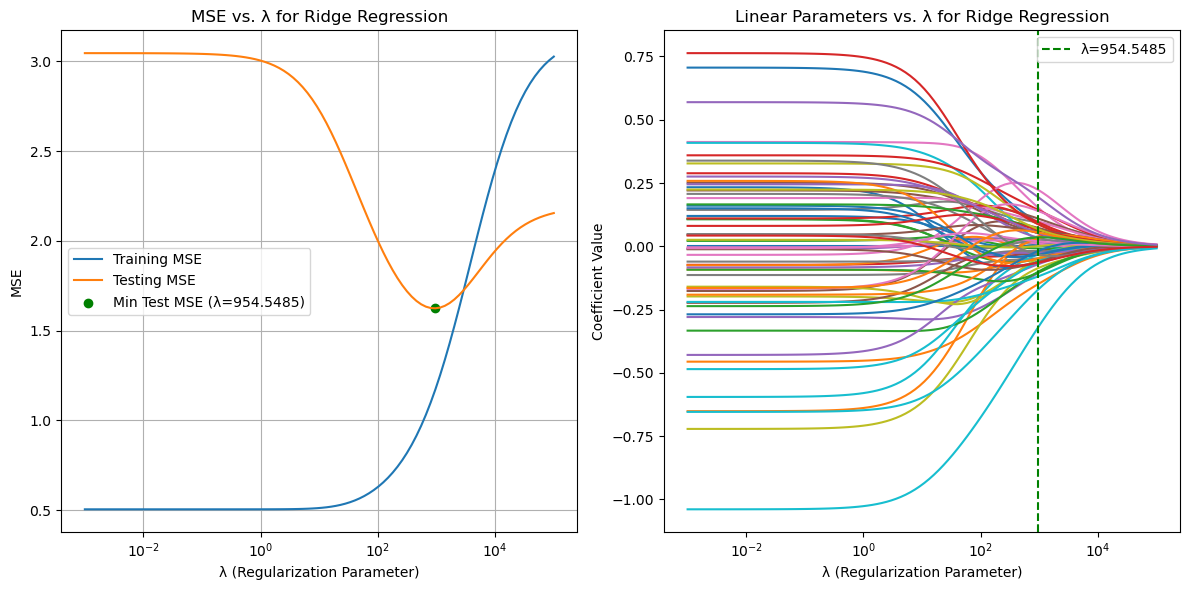

In [20]:
# Plot the evolution of MSE on training and testing data as a function of λ
plt.figure(figsize=(12, 6))

# First subplot for MSE
plt.subplot(1, 2, 1)
plt.semilogx(lambda_values, mse_train_values, label='Training MSE')
plt.semilogx(lambda_values, mse_test_values, label='Testing MSE')
plt.scatter(best_lambda, mse_test_values[best_lambda_index], color='green', label=f'Min Test MSE (λ={best_lambda:.4f})')
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('MSE')
plt.title('MSE vs. λ for Ridge Regression')
plt.legend()
plt.grid(True)

# Second subplot for linear parameters
plt.subplot(1, 2, 2)
for i in range(coefficients.shape[1]):
    plt.semilogx(lambda_values, coefficients[:, i])
    plt.axvline(best_lambda, color='green', linestyle='--', label=f'λ={best_lambda:.4f}')
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Coefficient Value')
plt.title('Linear Parameters vs. λ for Ridge Regression')
plt.legend()

plt.tight_layout()
plt.show()

The left plot shows training and testing mean squared errors (MSE) against different λ values, illustrating the trade-off between model complexity and performance.
The green dot and dashed line indicate the λ value associated with the lowest testing MSE, representing the optimal regularization parameter for best model performance.

The right plot displays how the linear coefficients change with λ.
Each curve represents the coefficient of a specific feature.
Higher λ values result in simpler models with coefficients tending towards zero.
The vertical green line marks the λ value corresponding to the best test MSE.

These plots help understand the impact of regularization on model performance and coefficient adjustments, providing insight into the choice of the optimal λ for ridge regression.

In [21]:
params_ridge = train_and_evaluate_ridge(alpha=best_lambda, print_results=True)

Ridge Regression with λ = 954.5484566618347

Training MSE: 1.1719
Training R2: 0.6268
Test MSE: 1.6239
Test R2: 0.2385


With the best lambda we identified for Ridge regression, we re-evaluated the model's performance by running it again. The outcomes substantially surpass those of a simple least squares (LS) algorithm. Remarkably, for the first time, we have a model that genuinely captures patterns, as evidenced by a positive R2 score. Notably, the training results are not as strong as those of the LS algorithm, yet the test results excel.

This phenomenon highlights the importance of not solely relying on superior training results, as it could indicate overfitting, wherein the model is too tailored to the training data to generalize effectively to new, unseen data.

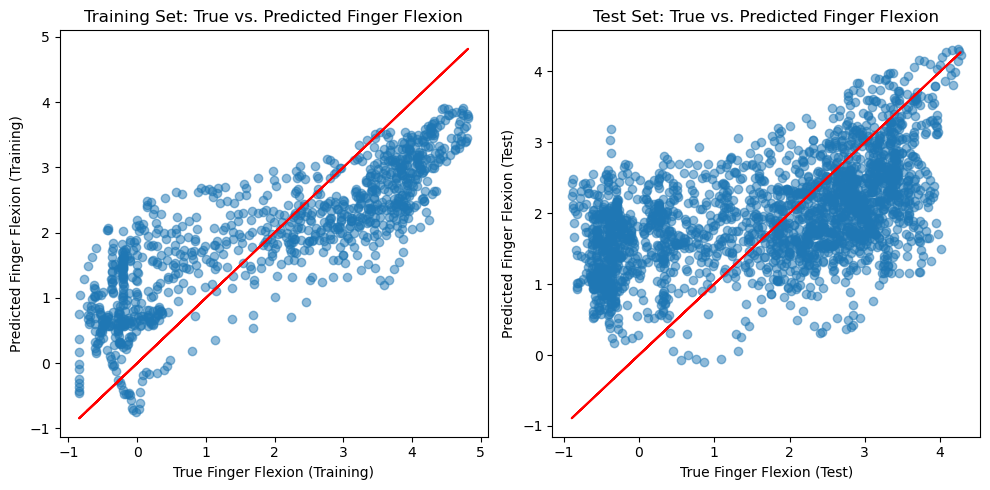

In [22]:
# Scatter plot for training set

Y_train_pred_ridge = params_ridge['Y_train_pred_ridge']
Y_test_pred_ridge = params_ridge['Y_test_pred_ridge']


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred_ridge, alpha=0.5)
plt.plot(Y_train,Y_train, c='r')
plt.xlabel('True Finger Flexion (Training)')
plt.ylabel('Predicted Finger Flexion (Training)')
plt.title('Training Set: True vs. Predicted Finger Flexion')

# Scatter plot for test set
plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred_ridge, alpha=0.5)
plt.plot(Y_test,Y_test, c='r')
plt.xlabel('True Finger Flexion (Test)')
plt.ylabel('Predicted Finger Flexion (Test)')
plt.title('Test Set: True vs. Predicted Finger Flexion')

plt.tight_layout()
plt.show()

The ideal model is depicted by the red line. It's evident that we achieve a superior fit for the training set when compared to the test set, given that the training data is better aligned with the red line.

Notably, it's worth mentioning that particularly for the test set, the model performs less effectively at lower sensor values. We'll further investigate this behavior in the upcoming plot to gain insights.

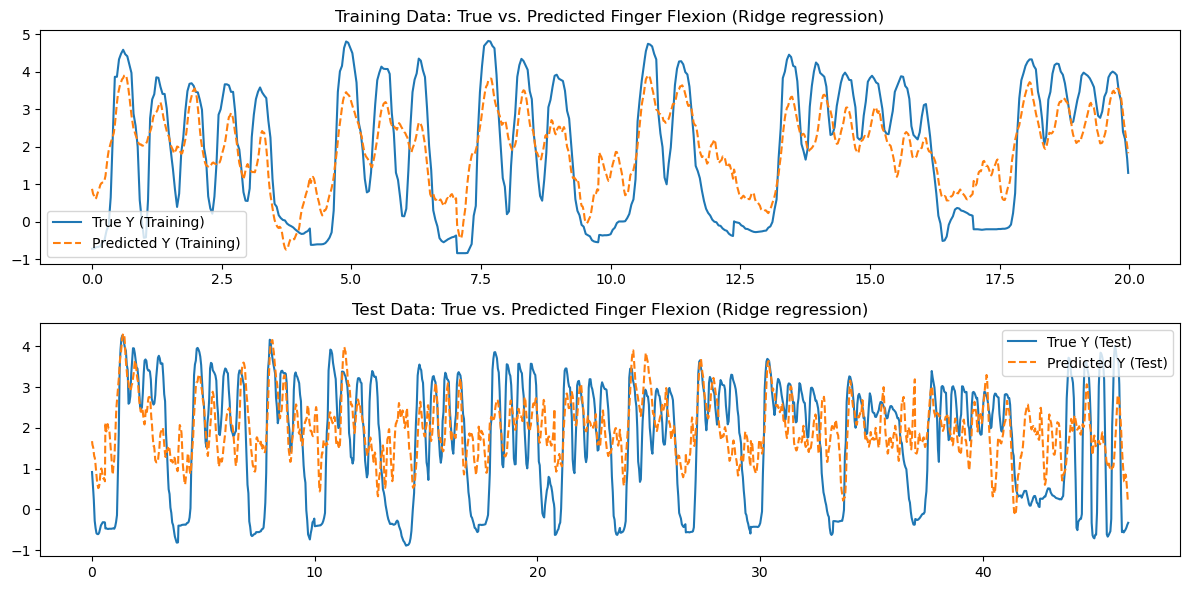

In [23]:
plot_train_test(Y_train_pred_ridge, Y_test_pred_ridge, "Ridge regression", time=True)

In this context, our primary focus shifts away from the training results, given that we're aware they are relatively satisfactory but somewhat diminished compared to the previous outcomes, likely because of a λ value greater than 1.

In terms of the test results, as anticipated from the scatter plot analysis, the model demonstrates worse performance with low sensor values. However, it exhibits commendable performance for the remaining range of sensor values.

**Remark :**

As time progresses, the algorithm's predictive accuracy seems to diminish. This phenomenon can be attributed to the complexity and evolving nature of the brain. Predicting long-term changes in electrode signals, particularly using a linear model, is exceptionally challenging.

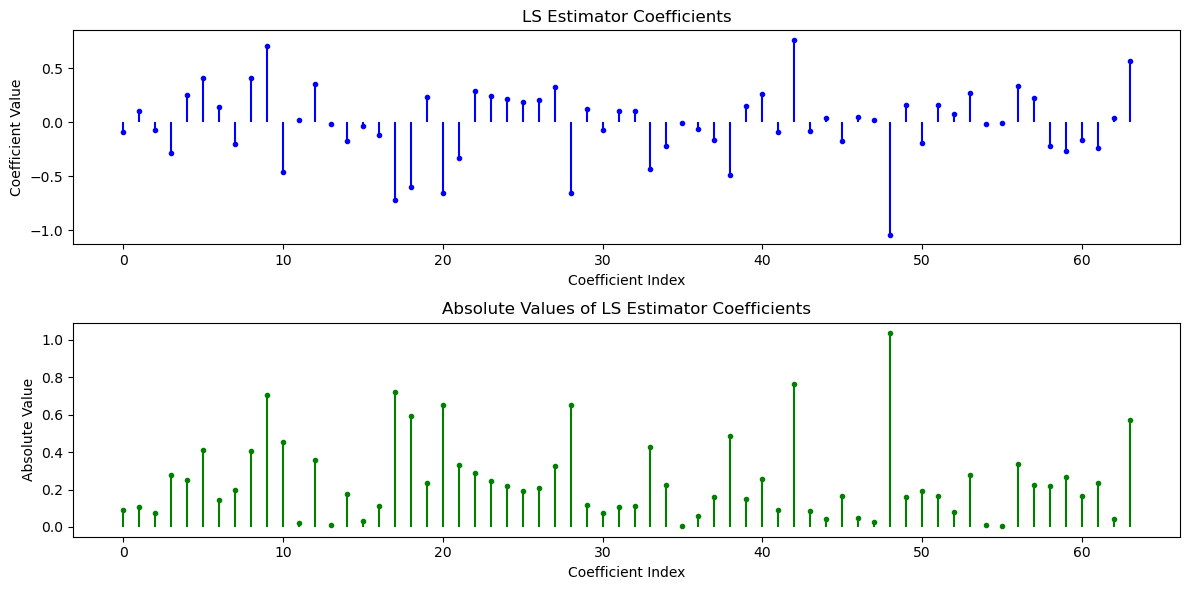

In [24]:
# Reshape the coefficients for LS estimator
LS_coefs = sklearn_coefs.reshape(-1)

# Plot LS estimator coefficients and their absolute values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(LS_coefs, basefmt=" ", markerfmt="b.", linefmt="b-")
plt.title("LS Estimator Coefficients")
plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 1, 2)
plt.stem(np.abs(LS_coefs), basefmt=" ", markerfmt="g.", linefmt="g-")
plt.title("Absolute Values of LS Estimator Coefficients")
plt.xlabel("Coefficient Index")
plt.ylabel("Absolute Value")

plt.tight_layout()
plt.show()

In [25]:
# Sort the variables by their absolute importance values in descending order
sorted_by_importance_variables = [index for index, value in sorted(enumerate(np.absolute(LS_coefs)), key=lambda x: x[1], reverse=True)]
print("Top 5 most important LS weights :\n\n ", sorted_by_importance_variables[:5])


Top 5 most important LS weights :

  [48, 42, 17, 9, 28]


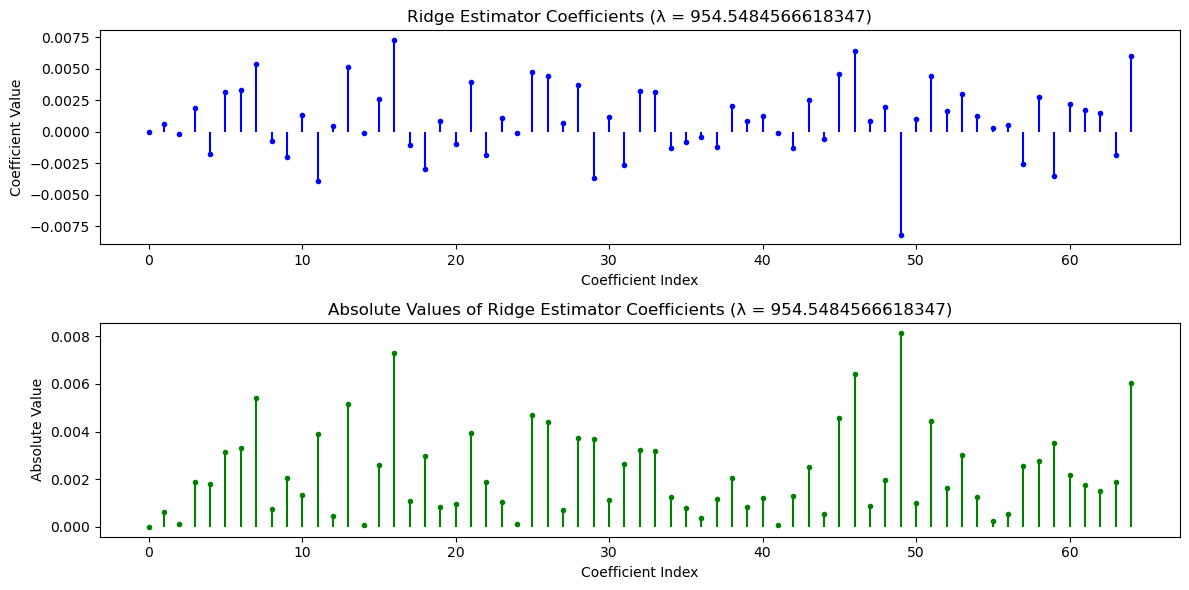

In [26]:
# Reshape the coefficients for Ridge estimator
ridge_coef = ridge_model.coef_.reshape(-1)

# Plot Ridge estimator coefficients and their absolute values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(ridge_coef, basefmt=" ", markerfmt="b.", linefmt="b-")
plt.title("Ridge Estimator Coefficients (λ = 954.5484566618347)")
plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 1, 2)
plt.stem(np.abs(ridge_coef), basefmt=" ", markerfmt="g.", linefmt="g-")
plt.title("Absolute Values of Ridge Estimator Coefficients (λ = 954.5484566618347)")
plt.xlabel("Coefficient Index")
plt.ylabel("Absolute Value")

plt.tight_layout()
plt.show()

In [27]:
# Sort the variables by their absolute importance values in descending order
sorted_by_importance_variables = [index for index, value in sorted(enumerate(np.absolute(ridge_coef)), key=lambda x: x[1], reverse=True)]
print("Top 5 most important Ridge weights :\n\n ", sorted_by_importance_variables[:5])

Top 5 most important Ridge weights :

  [49, 16, 46, 64, 7]


The small difference in the indices between the two lists likely indicates that the two models, LS and Ridge, identify similar features as important, and there may be an indexing inconsistency or minor variation in the data used for each model. If the difference is only one number, it's highly likely that the features are essentially the same, just indexed slightly differently in the two models.

In this case, the most important feature for both LS and Ridge is likely sensor 48, which is consistent with your previous findings in the lab.

## 4) Variable selection with the Lasso

In [28]:
# Create a Lasso regression model with the default alpha (regularization parameter)
lasso_model = Lasso()

# Fit the Lasso model to the training data
lasso_model.fit(X_tilde, Y_train)

Lasso()

In [29]:
# Predictions on the training set
Y_train_pred_lasso = lasso_model.predict(X_tilde)

# Predictions on the test set
X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
Y_test_pred_lasso = lasso_model.predict(X_test_tilde)

# Calculate performance metrics on training and test data
mse_train_lasso = mean_squared_error(Y_train, Y_train_pred_lasso)
r2_train_lasso = r2_score(Y_train, Y_train_pred_lasso)
mse_test_lasso = mean_squared_error(Y_test, Y_test_pred_lasso)
r2_test_lasso = r2_score(Y_test, Y_test_pred_lasso)

# Print performance metrics
print("Lasso Regression Performance Metrics:\n")
print(f"Training MSE: {mse_train_lasso:.4f}")
print(f"Training R2: {r2_train_lasso:.4f}")
print(f"Test MSE: {mse_test_lasso:.4f}")
print(f"Test R2: {r2_test_lasso:.4f}")

# Inspect the estimated linear model coefficients (Lasso)
lasso_coefs = lasso_model.coef_
print("\nEstimated Lasso Coefficients:")
print(lasso_coefs)


Lasso Regression Performance Metrics:

Training MSE: 3.1406
Training R2: 0.0000
Test MSE: 2.1907
Test R2: -0.0273

Estimated Lasso Coefficients:
[ 0.  0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0.
 -0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0. -0.
 -0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.  0.  0. -0.  0. -0.  0.  0.  0. -0.  0.]


The lasso regression model, with its default lambda, performs poorly with a high test MSE (2.1907) and a negative test R2 (-0.0273). This subpar performance can be attributed to its aggressive feature selection, which may exclude important variables. In contrast, ridge regression with default lambda maintains all features, often performing better when all features are relevant for prediction.

It is also worth noticing that it also do perform really bad and worse than default Ridge for training data. The fact that we have a null R2 suggests that the model explains no variance in the training data.

Let's see what is happening for the optimal Lasso lambda.

In [30]:
# Define a range of regularization parameters (λ)
lst_reg = np.logspace(-3, 5, 100)

# Initialize empty lists to store MSE values for training and testing
mse_train_values = []
mse_test_values = []

# Initialize empty lists to store Lasso coefficients
lasso_coefficients = []

# Iterate over each regularization parameter
for i, reg in enumerate(lst_reg):
    # Create and fit the Lasso model for the current λ
    lasso_model = Lasso(alpha=reg)
    lasso_model.fit(X_tilde, Y_train)

    # Predictions on the training set
    Y_train_pred = lasso_model.predict(X_tilde)

    # Predictions on the test set
    X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    Y_test_pred = lasso_model.predict(X_test_tilde)

    # Calculate MSE for training and testing
    mse_train = mean_squared_error(Y_train, Y_train_pred)
    mse_test = mean_squared_error(Y_test, Y_test_pred)

    # Append MSE values to the lists
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

    # Append Lasso coefficients
    lasso_coefficients.append(lasso_model.coef_)

# Find the index of the minimum MSE value
min_mse_index = np.argmin(mse_test_values)
min_mse_lambda = lst_reg[min_mse_index]
min_mse_value = mse_test_values[min_mse_index]


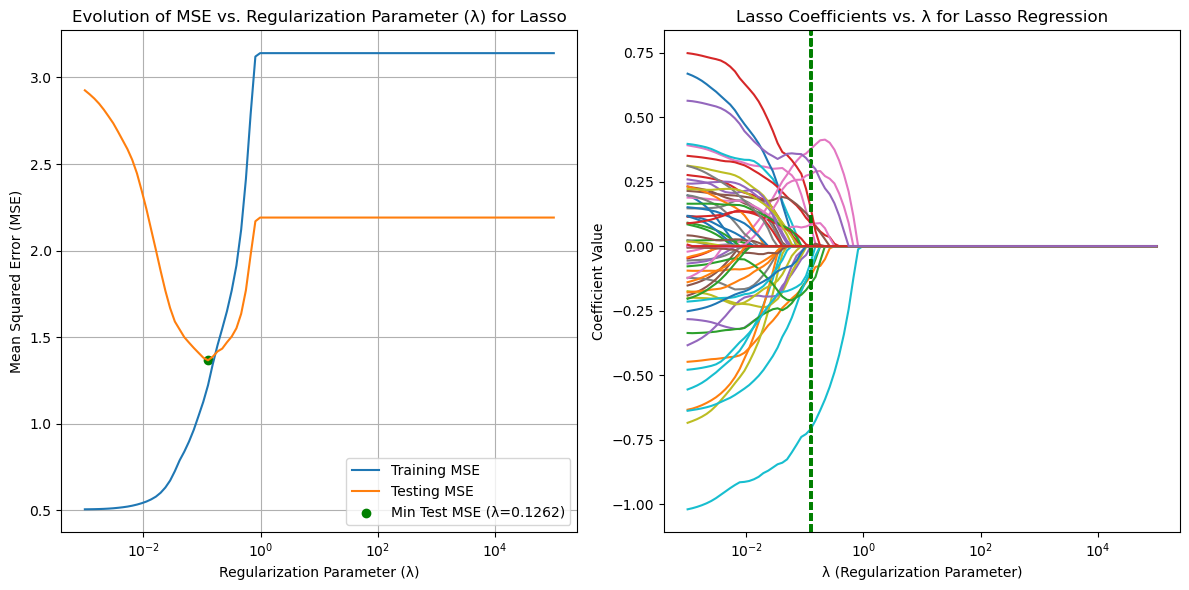

In [31]:
# Plot the evolution of MSE on training and testing data as a function of λ
plt.figure(figsize=(12, 6))

# First subplot for MSE
plt.subplot(1, 2, 1)
plt.semilogx(lst_reg, mse_train_values, label='Training MSE')
plt.semilogx(lst_reg, mse_test_values, label='Testing MSE')
plt.scatter(min_mse_lambda, min_mse_value, color='green', label=f'Min Test MSE (λ={min_mse_lambda:.4f})')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Evolution of MSE vs. Regularization Parameter (λ) for Lasso')
plt.legend()
plt.grid(True)

# Second subplot for Lasso coefficients
plt.subplot(1, 2, 2)
lasso_coefficients = np.array(lasso_coefficients)
for i in range(lasso_coefficients.shape[1]):
    plt.semilogx(lst_reg, lasso_coefficients[:, i])
    plt.axvline(min_mse_lambda, color='green', linestyle='--', label=f'λ={min_mse_lambda:.4f}')
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients vs. λ for Lasso Regression')

plt.tight_layout()
plt.show()

Using the same method we can quite easely find the optimum lambda value for our minimum testing MSE. Here's lambda = 0.1261856883066021.

The second plot visualizes how the coefficients of the Lasso model change in response to varying values of λ.
Each curve represents the evolution of a specific coefficient as λ increases. When λ is low, coefficients can freely take on large values. As λ increases, coefficients tend to shrink towards zero.
The vertical green dashed line marks the λ value where the minimum testing MSE occurs, showing which coefficients are being retained and penalized in the optimal model.

This is a really interesting graph because it is worth seeing which coefficients are or not being retained on the best model. Lasso is thus a great feature selection/reduction tool !

In [32]:
# Find the index of the minimum test MSE
best_lambda_index = np.argmin(mse_test_values)

# Get the corresponding best lambda value
best_lambda = lst_reg[best_lambda_index]

# Create and fit the Lasso model with the best lambda
best_lasso_model = Lasso(alpha=best_lambda)
best_lasso_model.fit(X_tilde, Y_train)

# Predictions on the training set
Y_train_pred_lasso = best_lasso_model.predict(X_tilde)

# Predictions on the test set
X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
Y_test_pred_lasso = best_lasso_model.predict(X_test_tilde)

# Calculate performance best metrics on training and test data
mse_train_lasso = mean_squared_error(Y_train, Y_train_pred_lasso)
r2_train_lasso = r2_score(Y_train, Y_train_pred_lasso)
mse_test_lasso = mean_squared_error(Y_test, Y_test_pred_lasso)
r2_test_lasso = r2_score(Y_test, Y_test_pred_lasso)

# Print performance metrics
print("Lasso Regression Performance Metrics:\n")
print(f"Training MSE: {mse_train_lasso:.4f}")
print(f"Training R2: {r2_train_lasso:.4f}")
print(f"Test MSE: {mse_test_lasso:.4f}")
print(f"Test R2: {r2_test_lasso:.4f}")

Lasso Regression Performance Metrics:

Training MSE: 1.2216
Training R2: 0.6110
Test MSE: 1.3660
Test R2: 0.3595


Metrics are a tiny bit worse on training data than for Ridge but much better on test data, let's plot the curves to see the behaviour.

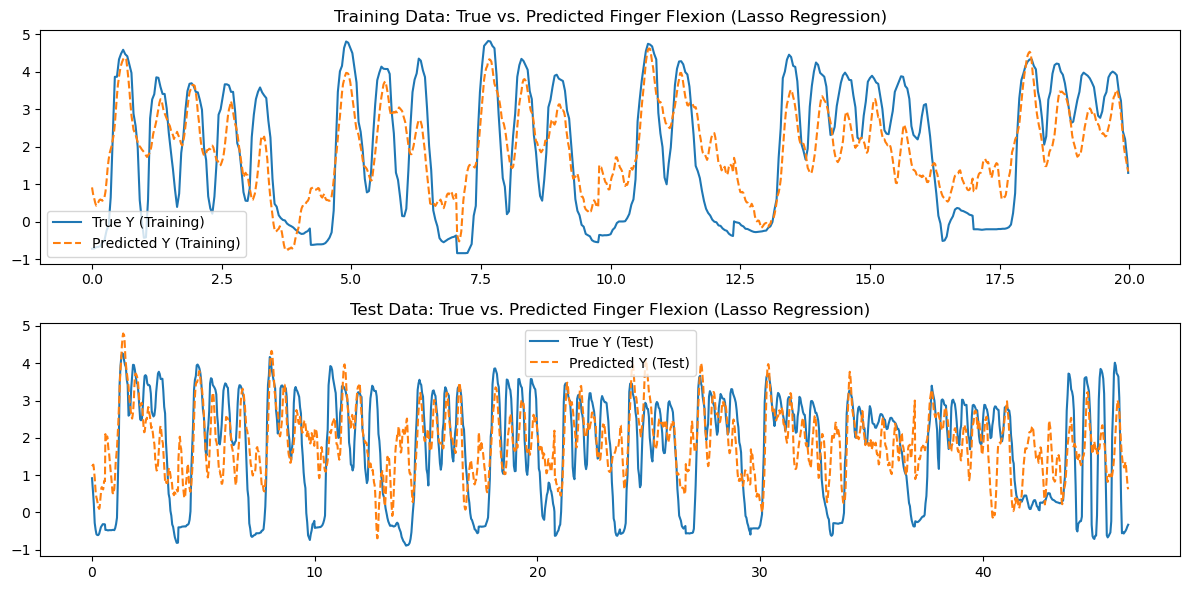

In [61]:
plot_train_test(Y_train_pred_lasso, Y_test_pred_lasso, 'Lasso Regression', time=True)


Predictions for training data are pretty good, close too the result we had for Ridge but our primary focus is in the results for test data.

For the test data it is quite good, the difference with Ridge is not breathtaking but we can clearly see that the the curves are more accurate, there are maching in a better way the amplitudes of the true data.

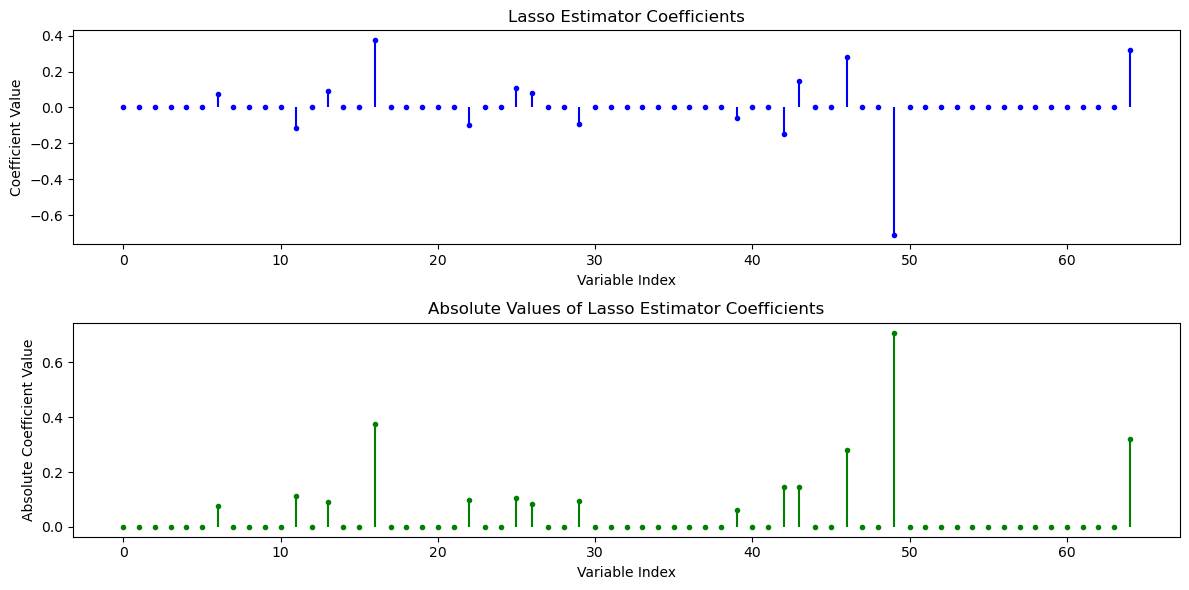

The five most important variables are: [49 16 64 46 43]


In [41]:
# Get the coefficients and their absolute values from the Lasso model
lasso_coefs = best_lasso_model.coef_
lasso_abs_coefs = np.abs(lasso_coefs)

# Create an array of variable indices for labeling the coefficients
variable_indices = np.arange(0, len(lasso_coefs))

# Sort the coefficients and variable indices based on absolute coefficient values
sorted_indices = np.argsort(lasso_abs_coefs)[::-1]
sorted_coefs = lasso_coefs[sorted_indices]
sorted_variable_indices = variable_indices[sorted_indices]

# Plot the coefficients and their absolute values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(variable_indices, lasso_coefs, basefmt=" ", markerfmt="b.", linefmt="b-")
plt.title("Lasso Estimator Coefficients")
plt.xlabel("Variable Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 1, 2)
plt.stem(variable_indices, lasso_abs_coefs, basefmt=" ", markerfmt="g.", linefmt="g-")
plt.title("Absolute Values of Lasso Estimator Coefficients")
plt.xlabel("Variable Index")
plt.ylabel("Absolute Coefficient Value")

plt.tight_layout()
plt.show()

# Print the indices of the two most important variables
most_important_variables = sorted_variable_indices[:5]
print("The five most important variables are:", most_important_variables)


The five most important variables identified with optimal Ridge were [49, 16, 46, 64, 7].

The two most important features remain the same, which is reassuring. However, we observe differences in importance for other features, as the models assign distinct levels of significance to them.

**Remark:**

The null values correspond to the features rejected by the Lasso algorithm, as observed in the previous plot. The reduction in features is, in my opinion, the root cause of the disparities in feature importance that the two models assign. Features that were less important in Ridge might act as noise and obscure the true importance values of other features when compared to Lasso.

In [34]:
# Count the number of non-zero coefficients in the Lasso model
num_selected_features = np.sum(lasso_coefs != 0)

# Print the number of selected features
print("Number of selected features by Lasso:", num_selected_features)


Number of selected features by Lasso: 14


Out of the 64 features, the Lasso model retained only 14. This implies that we might achieve improved results if the patient were equipped with just 14 electrodes. However, it's essential to note that the placement of these electrodes is likely crucial. Having information about the optimal electrode placement could greatly assist in understanding if specific electrode locations contribute more effectively to the model's performance than others.

## 5) Nonlinear regression


### 1) Random Forest

In [52]:
# Create and fit the RandomForestRegressor with default parameters
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the train/test set
Y_train_pred_rf = rf_regressor.predict(X_train)
Y_test_pred_rf = rf_regressor.predict(X_test)

# Compute performance metrics
mse_train_rf = mean_squared_error(Y_train, Y_train_pred_rf)
r2_train_rf = r2_score(Y_train, Y_train_pred_rf)
mse_test_rf = mean_squared_error(Y_test, Y_test_pred_rf)
r2_test_rf = r2_score(Y_test, Y_test_pred_rf)

print("RandomForestRegressor Performance Metrics:\n")
print(f"Train MSE: {mse_train_rf:.4f}")
print(f"Train R2: {r2_train_rf:.4f}")
print(f"Test MSE: {mse_test_rf:.4f}")
print(f"Test R2: {r2_test_rf:.4f}")


RandomForestRegressor Performance Metrics:

Train MSE: 0.0234
Train R2: 0.9926
Test MSE: 1.6686
Test R2: 0.2175


The Random Forest model performs exceptionally well on the training data and demonstrates a solid performance on the test data, even with default parameters. It's intriguing to explore how the test data results differ between default and optimal parameters. Do non-linear methods exhibit different behavior compared to linear ones? Let's investigate this aspect.

In [53]:
# Define the hyperparameters and their possible values
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestRegressor
rf_regressor = RandomForestRegressor()

# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist,
                                   n_iter=10, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the random search to the data
random_search.fit(X_train, Y_train.ravel())

# Get the best hyperparameters
best_params = random_search.best_params_

# Create a RandomForestRegressor with the best hyperparameters
best_rf_regressor = RandomForestRegressor(**best_params)

# Fit the model with the best hyperparameters
best_rf_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the test/train set
Y_train_pred_best_rf = best_rf_regressor.predict(X_train)
Y_test_pred_best_rf = best_rf_regressor.predict(X_test)

# Compute performance metrics with the best hyperparameters
mse_train_rf = mean_squared_error(Y_train, Y_train_pred_best_rf)
r2_train_rf = r2_score(Y_train, Y_train_pred_best_rf)
mse_test_rf = mean_squared_error(Y_test, Y_test_pred_best_rf)
r2_test_rf = r2_score(Y_test, Y_test_pred_best_rf)

print("Best RandomForestRegressor Performance Metrics:")
print(f"Train MSE: {mse_train_rf:.4f}")
print(f"Train R2: {r2_train_rf:.4f}")
print(f"Test MSE: {mse_test_rf:.4f}")
print(f"Test R2: {r2_test_rf:.4f}")

print("Best Hyperparameters:", best_params)

Best RandomForestRegressor Performance Metrics:
Train MSE: 0.0274
Train R2: 0.9913
Test MSE: 1.6726
Test R2: 0.2157
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


The Random Forest's initial default settings are robust, providing quite strong performance. Unlike linear models, Random Forest already captures complex, non-linear relationships effectively. Consequently, the relative impact of parameter optimization is often less significant, especially when the data structure is not highly complex, making improvements between default and optimal settings more modest in comparison to linear models.

We can expect that we will have the same kind of behaviour for the other non-linear methods.

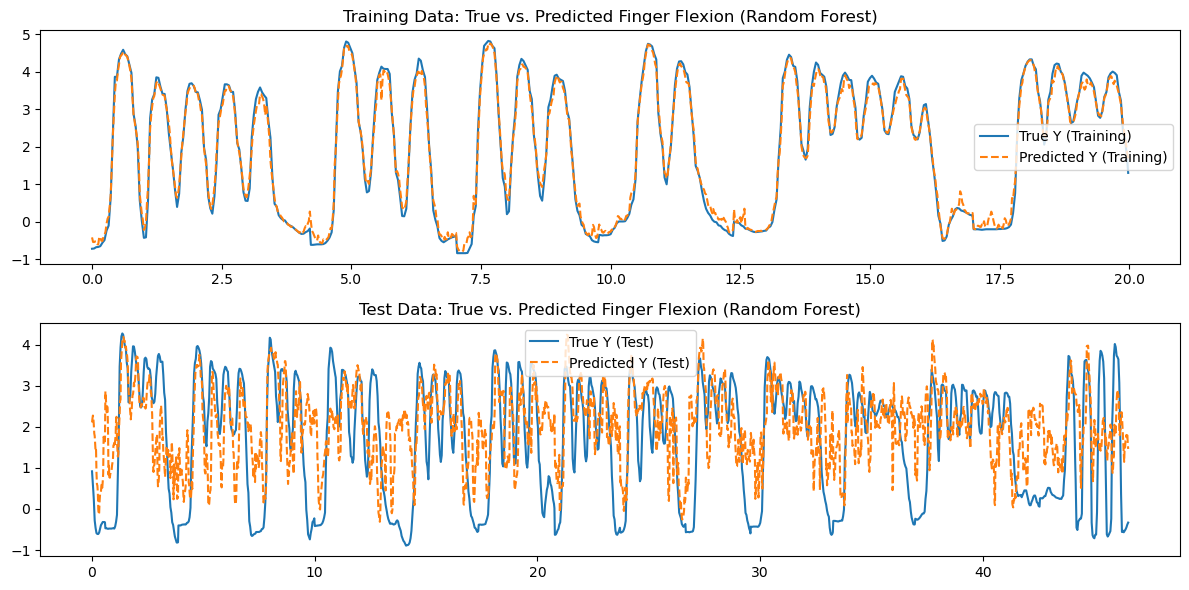

In [54]:
plot_train_test(Y_train_pred_best_rf, Y_test_pred_best_rf, "Random Forest", time=True)

Our results with Random forest are not bad at all. Lasso and Ridge seems to behave a bit better on test data. It is really impressive how the non-linear model here predicts perfectly the training data, it thus seems to overfit very easely with our data.

### 2) SVR

In [45]:
# Create and fit the SVR with default parameters
svr_regressor = SVR()
svr_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the train/test set
Y_train_pred_svr = svr_regressor.predict(X_train)
Y_test_pred_svr = svr_regressor.predict(X_test)

# Compute performance metrics
mse_train_svr = mean_squared_error(Y_train, Y_train_pred_svr)
r2_train_svr = r2_score(Y_train, Y_train_pred_svr)
mse_test_svr = mean_squared_error(Y_test, Y_test_pred_svr)
r2_test_svr = r2_score(Y_test, Y_test_pred_svr)

print("SVR Performance Metrics:\n")
print(f"Train MSE: {mse_train_svr:.4f}")
print(f"Train R2: {r2_train_svr:.4f}")
print(f"Test MSE: {mse_test_svr:.4f}")
print(f"Test R2: {r2_test_svr:.4f}")

SVR Performance Metrics:

Train MSE: 0.0241
Train R2: 0.9923
Test MSE: 1.5152
Test R2: 0.2895


We have here the same behavior than for Random Forest, let's see how it goes with optimal paramaters, will it change a lot ?

In [47]:
# Define the SVR model
svr = SVR()

# Define a reduced parameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
}

# Perform a grid search using cross-validation
grid_search = GridSearchCV(svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to your training data
grid_search.fit(X_train, Y_train.ravel())

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Predict on the test/train set
Y_train_pred_svr = best_svr.predict(X_train)
Y_test_pred_svr = best_svr.predict(X_test)

# Calculate performance metrics on test data
mse_train_svr = mean_squared_error(Y_train, Y_train_pred_svr)
r2_train_svr = r2_score(Y_train, Y_train_pred_svr)
mse_test_svr = mean_squared_error(Y_test, Y_test_pred_svr)
r2_test_svr = r2_score(Y_test, Y_test_pred_svr)

# Print the results
print(f"Best SVR Model Parameters: {best_svr.get_params()}")
print(f"Train MSE: {mse_train_svr:.4f}")
print(f"Train R2: {r2_train_svr:.4f}")
print(f"Test MSE: {mse_test_svr:.4f}")
print(f"Test R2: {r2_test_svr:.4f}")


Best SVR Model Parameters: {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Train MSE: 0.0062
Train R2: 0.9980
Test MSE: 1.5526
Test R2: 0.2719


Here the results is quite interesting. After trying with the same method than before (RandomizedSearchCV) I had a worse result than for training data. Suprised i though I did a mistake but while changing my code and trying another method, here with GridSearchCV, I have better results but still than with default parameters.

After doing some research, I realized that the parameters returned by the grid search may not be ideal for our specific dataset. Grid search optimizes over the specified parameter space, but the best parameter values may not necessarily lead to the best performance for your data.
It also underlines that default paramaters for SVR are pretty well defined!

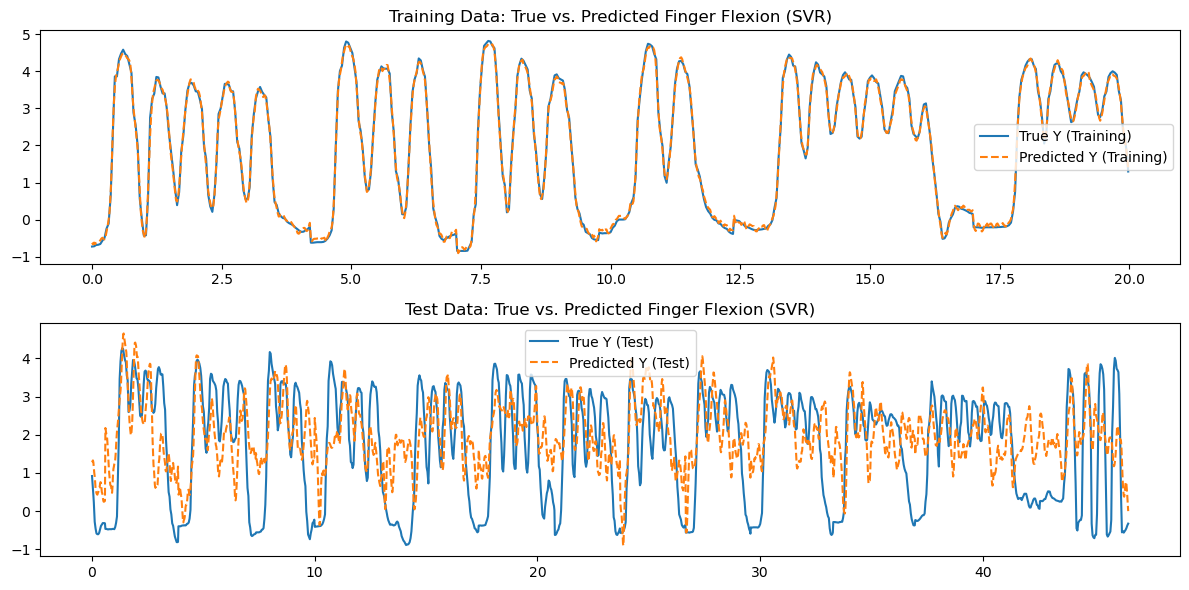

In [48]:
plot_train_test(Y_train_pred_svr, Y_test_pred_svr, "SVR", time=True)

The plot result reflects what we sac in the metrics. Pefect model on training and also a decent one on test data but not as good as some linear models.

We start to understand here that the complexity of a model is not always the best performer. Let's see if the last models will still be worse than our current winners.

### 3) MLP

The LAB suggets that we use an MLP Classifier. Obviously I will not try it because it makes no sense as we do not want to classify anything, we want to predict continous values and thus we have to work with regression methods.

I still wanted do try MLP so we'll use an MLPRegressor that fits better with the LAB.

In [56]:
# Create and fit the MLPRegressor with default parameters
mlp_regressor = MLPRegressor()
mlp_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the train/test set
Y_train_pred_mlp = mlp_regressor.predict(X_train)
Y_test_pred_mlp = mlp_regressor.predict(X_test)

# Compute performance metrics
mse_train_mlp = mean_squared_error(Y_train, Y_train_pred_mlp)
r2_train_mlp = r2_score(Y_train, Y_train_pred_mlp)
mse_test_mlp = mean_squared_error(Y_test, Y_test_pred_mlp)
r2_test_mlp = r2_score(Y_test, Y_test_pred_mlp)

print("MLPRegressor Performance Metrics:\n")
print(f"Train MSE: {mse_train_mlp:.4f}")
print(f"Train R2: {r2_train_mlp:.4f}")
print(f"Test MSE: {mse_test_mlp:.4f}")
print(f"Test R2: {r2_test_mlp:.4f}")

MLPRegressor Performance Metrics:

Train MSE: 0.0078
Train R2: 0.9975
Test MSE: 2.3632
Test R2: -0.1082


It is a bad day for the deep learning community. The MLP is awful on our data. It learns pefectly the training set (gold medal for it) but thus shows an important overfitting that gives us pretty bad test results... with a great negative R2, our model doesn't learn anything.

Do the paramters of the MLP will change anything ?don't think so but let's try.

In [57]:
# Define a range of values for hyperparameters
param_dist = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Create the MLP regressor
mlp_regressor = MLPRegressor(random_state=42)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    mlp_regressor, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train, Y_train.ravel())  # X_train and Y_train are your training data

# Print the best hyperparameters and corresponding test performance
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Test MSE: ", -random_search.best_score_)

# Predict on the test/train data using the best model found by RandomizedSearchCV
best_model = random_search.best_estimator_
Y_test_pred_mlp = best_model.predict(X_test)
Y_train_pred_mlp = best_model.predict(X_train)

# Calculate R2 score on the test data
r2_train_mlp = r2_score(Y_train, Y_train_pred_mlp)
mse_train_mlp = mean_squared_error(Y_train, Y_train_pred_mlp)
r2_test_mlp = r2_score(Y_test, Y_test_pred_mlp)
mse_test_mlp = mean_squared_error(Y_test, Y_test_pred_mlp)

print("Best MLPRegressor Performance Metrics:\n")
print(f"Train MSE: {mse_train_mlp:.4f}")
print(f"Train R2: {r2_train_mlp:.4f}")
print(f"Test MSE: {mse_test_mlp:.4f}")
print(f"Test R2: {r2_test_mlp:.4f}")

Best Hyperparameters:  {'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100), 'activation': 'tanh'}
Best Test MSE:  1.855526615191939
Best MLPRegressor Performance Metrics:

Train MSE: 0.0088
Train R2: 0.9972
Test MSE: 2.2874
Test R2: -0.0726


We almost have no change with the best parameters, not suprising, we do start to understand how non-linear models work on our data.

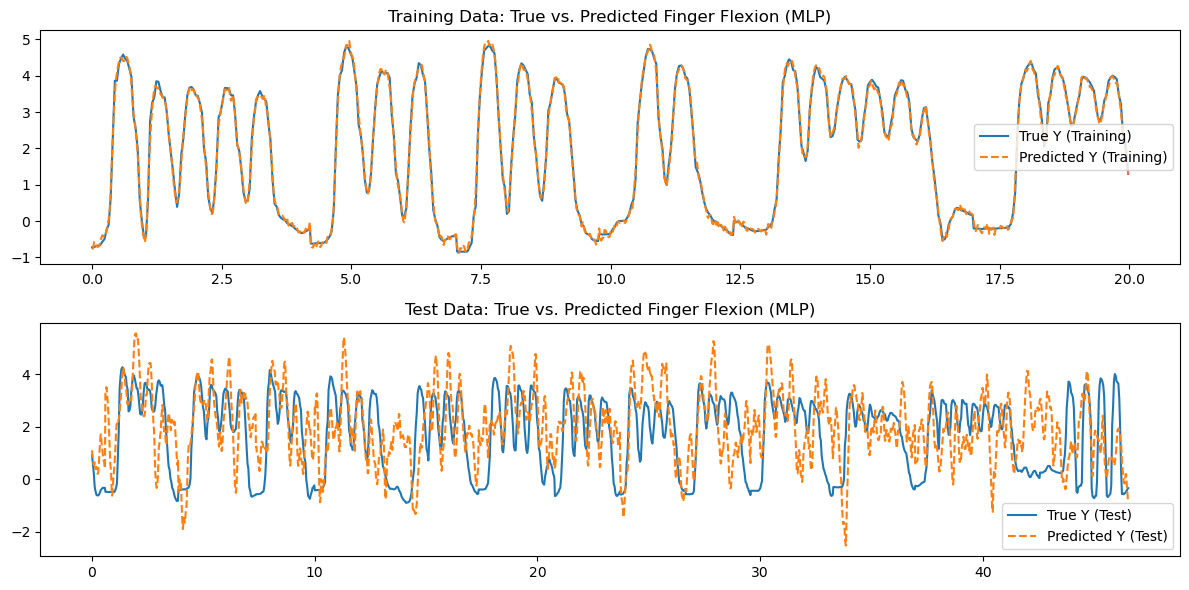

In [58]:
plot_train_test(Y_train_pred_mlp, Y_test_pred_mlp, 'MLP', time=True)

The MLP is the worst non-linear model for now. It is great to see that neural networks models are not the always the best! We have to keep working with more basic models first and especially if we do not have enough data to work well with these kinds of model.

### 4) GDR

Let's try a last method, even though I'm already not convinced about non-linear methods for our dataset.

In [49]:
# Create and fit the GradientBoostingRegressor with default parameters
gbr_regressor = GradientBoostingRegressor()
gbr_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the train/test set
Y_train_pred_gbr = gbr_regressor.predict(X_train)
Y_test_pred_gbr = gbr_regressor.predict(X_test)

# Compute performance metrics
mse_train_gbr = mean_squared_error(Y_train, Y_train_pred_gbr)
r2_train_gbr = r2_score(Y_train, Y_train_pred_gbr)
mse_test_gbr = mean_squared_error(Y_test, Y_test_pred_gbr)
r2_test_gbr = r2_score(Y_test, Y_test_pred_gbr)

print("GradientBoostingRegressor Performance Metrics:\n")
print(f"Train MSE: {mse_train_gbr:.4f}")
print(f"Train R2: {r2_train_gbr:.4f}")
print(f"Test MSE: {mse_test_gbr:.4f}")
print(f"Test R2: {r2_test_gbr:.4f}")


GradientBoostingRegressor Performance Metrics:

Train MSE: 0.1133
Train R2: 0.9639
Test MSE: 1.6798
Test R2: 0.2123


In [50]:
# Define a range of values for hyperparameters
param_dist = {
    'n_estimators': [50, 100, 150, 200],  # You can extend this list
    'max_depth': [3, 4, 5, 6],  # You can extend this list
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # You can extend this list
}

# Create the GradientBoostingRegressor
gbr_regressor = GradientBoostingRegressor(random_state=42)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    gbr_regressor, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train, Y_train.ravel())  # X_train and Y_train are your training data

# Print the best hyperparameters and corresponding test performance
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Test MSE: ", -random_search.best_score_)

# Predict on the test/train data using the best model found by RandomizedSearchCV
best_model = random_search.best_estimator_
Y_test_pred_gbr = best_model.predict(X_test)
Y_train_pred_gbr = best_model.predict(X_train)

# Calculate R2 score on the test data
r2_train_gbr = r2_score(Y_train, Y_train_pred_gbr)
mse_train_gbr = mean_squared_error(Y_train, Y_train_pred_gbr)
r2_test_gbr = r2_score(Y_test, Y_test_pred_gbr)
mse_test_gbr = mean_squared_error(Y_test, Y_test_pred_gbr)

print("Best GradientBoostingRegressor Performance Metrics:\n")
print(f"Train MSE: {mse_train_gbr:.4f}")
print(f"Train R2: {r2_train_gbr:.4f}")
print(f"Test MSE: {mse_test_gbr:.4f}")
print(f"Test R2: {r2_test_gbr:.4f}")


Best Hyperparameters:  {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Best Test MSE:  1.9421695689759162
Best GradientBoostingRegressor Performance Metrics:

Train MSE: 0.2742
Train R2: 0.9127
Test MSE: 1.6810
Test R2: 0.2117


The GBR is the method that has changed the less with optimal parameters. The default parameters are great. We see that it is the non-linear method that seems to overfit the less. The metrics are not so bad but still worse than for linear methods.

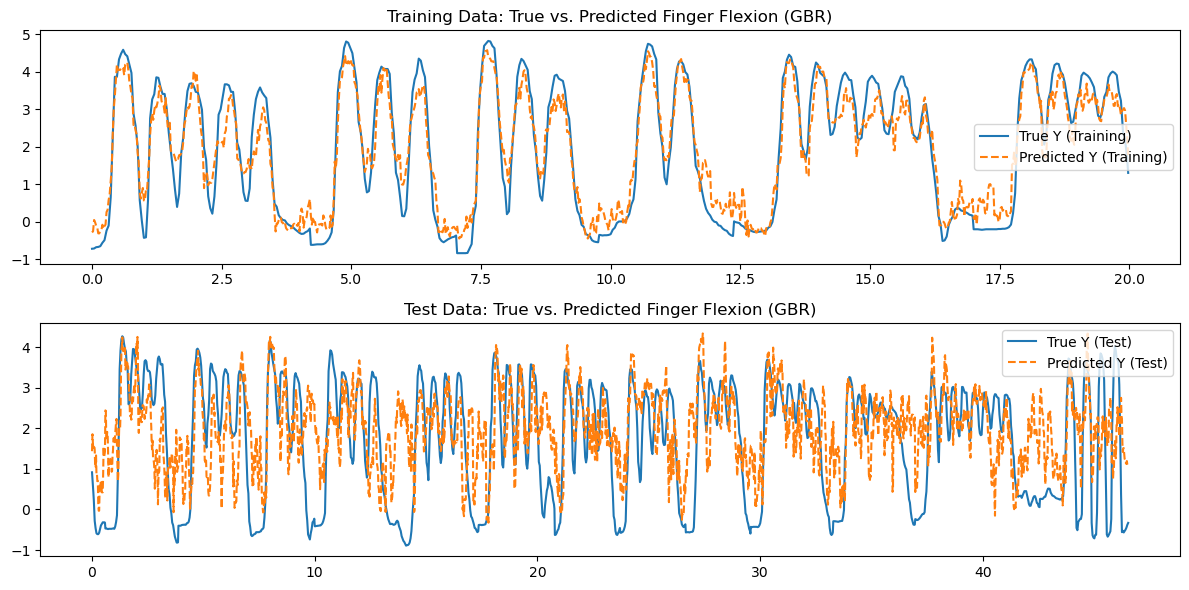

In [75]:
plot_train_test(Y_train_pred_gbr, Y_test_pred_gbr, 'GBR', time=True)

As the metrics showed, it overtfits less than the other non-linear methods but still more than linear ones.


## 6) Final comparison of the performances

In [59]:
data = {
"LS" : [mse_test_ls,r2_test_ls],
"Ridge" : [params_ridge['mse_test_ridge'],params_ridge['r2_test_ridge']],
"Lasso" : [mse_test_lasso,r2_test_lasso],
"Random Forest" :[mse_test_rf,r2_test_rf],
"SVR" : [mse_test_svr,r2_test_svr],
"MLP" : [mse_test_mlp,r2_test_mlp],
"GBR" : [mse_test_gbr,r2_test_gbr]
}

# Create a DataFrame
df = pd.DataFrame(data, index=["MSE", "R²"])

# Applying a style to have a better result :)
styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

# Plot the dataframe
styled_df

,LS,Ridge,Lasso,Random Forest,SVR,MLP,GBR
MSE,3.045537,1.623906,1.365954,1.672554,1.552581,2.287393,1.681030
R²,-0.428170,0.238488,0.359451,0.215675,0.271935,-0.072647,0.211700


**• Which methods work the best in practice?**

In practical terms, for the given train and test dataset, **Lasso** with a customized lambda parameter emerges as the best method. It achieves the highest performance on the test data, making it a top choice for predictive accuracy. The reason for this preference lies in the fact that non-linear algorithms, such as **Random Forest** and **SVR**, while excelling on training data, often struggle with overfitting and exhibit poor generalization to test data. "Lasso," as a linear model with L1 regularization, strikes a balance between prediction accuracy and model simplicity.

**• What are the most interpretable models?**

**Lasso**, **Ridge** and **Linear Regression (LS)** are the most interpretable models. These linear models offer a high level of interpretability due to their simple structure and the direct relationships between input features and the target variable (here sensors for instance). Additionally, **Lasso** provides feature selection capabilities by setting some coefficients to zero, further enhancing interpretability.

While **Random Forest**, **SVR**, and **MLP** may offer strong predictive performance in some cases, they tend to be less interpretable due to their complex, non-linear nature. **Lasso**, **Ridge** and **Linear Regression** remain top choices when prioritizing model transparency and the ability to understand the factors influencing predictions.

**• Which model is best from a medical/practical perspective?**

From my perspective, it's evident that among all the models we've evaluated, **Lasso** emerges as the clear winner in terms of performance metrics and interpretability, making it the best choice from a medical and practical standpoint.

The remarkable aspect of the **Lasso** model is its feature reduction capability, which explicitly identifies that only 14 sensors out of the original 64 are essential. This insight is unique to Lasso and provides invaluable guidance that other models cannot offer. In fields like medicine, interpretability holds significant importance, often surpassing the need for marginal performance gains. The ability to comprehend and trust the model's decision-making is invaluable, making **Lasso** the preferred choice, even if it slightly sacrifices predictive performance in exchange for profound interpretability.

**• Do we need non-linearity in this application?**

In my view, the inclusion of non-linearity in our approach would have been more relevant if we had a significantly larger dataset. With ample data, linear models may struggle to capture complex relationships, while models like **MLP** could perform better due to reduced overfitting.

In summary, non-linearity, particularly in the case of **MLP** with a limited dataset, doesn't yield optimal results. The primary reason is that while **SVR** and **Random Forest** provide reasonable results, they tend to be less interpretable than linear models. While some non-linear models offer interpretability through feature importance scores, the level of transparency provided by **Lasso** in this application is unparalleled.

**• Is validation on the test data a good practice? What would you do if you need to provide a model to
a client for prediction in production?**

I would not say that validation on the test data is only a good practice, it is absolutely mandatory. This lab serves as a clear illustration of why. The **MLP** model, while seemingly perfect on the training data, performed poorly on the test data. Testing data results carry far greater importance than training results.

If I were to provide a model for production in this specific application, my primary recommendation would be to acquire more data. In domains like healthcare, diversifying the patient dataset and amassing a substantial volume of data is crucial. For instance, in vaccine validation, trials typically involve tens of thousands of participants, not merely a few subjects. Therefore, with a more extensive dataset, the need for non-linearity might have become evident.

## Conclusion - personal discussion on the lab

I really enjoyed this lab, even more than the first one. Working exclusively with a single dataset within the same lab provided a unique opportunity to delve deeply into it.

It was truly fascinating to observe how various models performed, both on the training and test data. The contrast between the linear and non-linear models was particularly enlightening. I must admit, the results of Lasso took me by surprise. I hadn't expected it to be as valuable as it turned out to be for our dataset.

While our course already emphasized starting with linear methods, this lab solidified the notion of their significance. Even if linear methods may not outperform non-linear ones in terms of predictive accuracy is some cases, the interpretability they offer is a priceless asset for our ongoing work.

This lab introduced me to the practical application of various machine learning algorithms, including Support Vector Regression (**SVR**) and Gradient Boosting Regression (**GBR**), as well as essential scikit-learn functions like **RandomizedSearchCV** and **GridSearchCV**. These tools are immensely helpful in identifying the optimal parameters for a model.

In a professional context, this lab serves as a valuable roadmap for approaching data, starting from exploration and experimentation, progressing to discovery and interpretation, and ultimately leading to conclusive insights. It reinforces the iterative and systematic approach to real-world problem-solving in the realm of machine learning.